In [ ]:
!pip install causalml
# !pip install -q xgboost
# !pip install -q lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 36.1 MB/s eta 0:00:00
  Using cached Cython-0.29.34-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━

# Custom function to generate uplift classification data
1. use it in `plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')` , so as to know the true uplift curve of the test data and compare it with that from the model for the test data.

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from random import choices
import pandas as pd

def custom_make_uplift_classification(
    n_samples=1000,
    treatments=['control', 'treatment_1', 'treatment_2'],
    treatment_proportions=None,
    treament_assignment=None,
    control_name='control',
    y_name='conversion',
    n_features=6,
    n_informative=2,
    n_redundant=1,
    n_repeated=1,
    n_classes=2,
    shift=0.0,
    scale=1.0,
    n_uplift_increase_dict={"treatment_1": 2, "treatment_2": 2},
    n_uplift_decrease_dict={"treatment_1": 0, "treatment_2": 0},
    delta_uplift_increase_dict={"treatment_1": 0.02, "treatment_2": 0.05},
    delta_uplift_decrease_dict={"treatment_1": 0.0, "treatment_2": 0.0},
    n_uplift_increase_mix_informative_dict={
        "treatment_1": 1,
        "treatment_2": 1
    },
    n_uplift_decrease_mix_informative_dict={
        "treatment_1": 0,
        "treatment_2": 0
    }
):

  # create a pandas DataFrame, this will be ultimately returned
  df_res = pd.DataFrame()

  if not (isinstance(shift, list) or isinstance(shift, np.ndarray)):
    shift = [0.0 for _ in range(n_features)]
  else:
    if (isinstance(shift, list) and len(shift) != n_features) or \
      (isinstance(shift, np.ndarray) and shift.shape[0] != n_features) :
      raise Exception("mismatch in length(shift) with n_features.")

  if not (isinstance(scale, list) or isinstance(scale, np.ndarray)):
    scale = [1.0 for _ in range(n_features)]
  else:
    if (isinstance(scale, list) and len(scale) != n_features) or \
      (isinstance(scale, np.ndarray) and scale.shape[0] != n_features) :
      raise Exception("mismatch in length(scale) with n_features.")

  if not treatment_proportions:
    treatment_proportions = [1/len(treatments) for _ in range(len(treatments))]

  if treament_assignment is None:
    treament_assignment = choices(
        population=treatments,
        weights=treatment_proportions,
        k=n_samples
    )
  df_res['treatment_group_key'] = treament_assignment

  X, y = make_classification(
      n_samples = n_samples,
      n_features = n_features,
      n_informative = n_informative,
      n_redundant = n_redundant,
      n_repeated = n_repeated,
      n_classes = n_classes,
      random_state=42
  )
  X += shift
  X *= scale

  x_name = []
  x_informative_name = []
  for xi in range(n_informative):
      x_name_i = "x" + str(len(x_name) + 1) + "_informative"
      x_name.append(x_name_i)
      x_informative_name.append(x_name_i)
      df_res[x_name_i] = X[:, xi]
  for xi in range(n_redundant):
      x_name_i = "x" + str(len(x_name) + 1) + "_redundant"
      x_name.append(x_name_i)
      df_res[x_name_i] = X[:, n_informative + xi]
  for xi in range(n_repeated):
      x_name_i = "x" + str(len(x_name) + 1) + "_repeated"
      x_name.append(x_name_i)
      df_res[x_name_i] = X[
          :, n_informative + n_redundant + xi
      ]

  for xi in range(
      n_features
      - n_informative
      - n_redundant
      - n_repeated
  ):
      x_name_i = "x" + str(len(x_name) + 1) + "_irrelevant"
      x_name.append(x_name_i)
      df_res[x_name_i] = np.random.normal(0, 1, n_samples)

  positive_class_proportion = 0.5

  # default treatment effects
  Y = y.copy()
  Y_increase = np.zeros_like(y)
  Y_decrease = np.zeros_like(y)

  # generate uplift (positive)
  for treatment_key_i in treatments:
    treatment_index = df_res.index[
        df_res["treatment_group_key"] == treatment_key_i
    ].tolist()
    if (
        treatment_key_i in n_uplift_increase_dict
        and n_uplift_increase_dict[treatment_key_i] > 0
    ):
        x_uplift_increase_name = []
        adjust_class_proportion = (delta_uplift_increase_dict[treatment_key_i]) / (
            1 - positive_class_proportion
        )
        X_increase, Y_increase = make_classification(
            n_samples=n_samples,
            n_features=n_uplift_increase_dict[treatment_key_i],
            n_informative=n_uplift_increase_dict[treatment_key_i],
            n_redundant=0,
            n_clusters_per_class=1,
            weights=[1 - adjust_class_proportion, adjust_class_proportion],
        )
        for xi in range(n_uplift_increase_dict[treatment_key_i]):
            x_name_i = "x" + str(len(x_name) + 1) + "_uplift_increase"
            x_name.append(x_name_i)
            x_uplift_increase_name.append(x_name_i)
            df_res[x_name_i] = X_increase[:, xi]
        Y[treatment_index] = Y[treatment_index] + Y_increase[treatment_index]
        if n_uplift_increase_mix_informative_dict[treatment_key_i] > 0:
            for xi in range(
                n_uplift_increase_mix_informative_dict[treatment_key_i]
            ):
                x_name_i = "x" + str(len(x_name) + 1) + "_increase_mix"
                x_name.append(x_name_i)
                df_res[x_name_i] = (
                    np.random.uniform(-1, 1)
                    * df_res[np.random.choice(x_informative_name)]
                    + np.random.uniform(-1, 1)
                    * df_res[np.random.choice(x_uplift_increase_name)]
                )

  # truncate Y
  Y = np.clip(Y, 0, 1)

  df_res[y_name] = Y
  df_res["treatment_effect"] = Y - y # true treatment effect for actual uplift curve

  return df_res, x_name

# Training Data 1: Imbalanced treatment assignment with single treatment group
- selection, EDA, feature engineering
- both treatment and outcomes are binary in nature, but treatment assignment is imbalanced, i.e. very few samples will be assigned to a treatment.

In [ ]:
df, feature_names = custom_make_uplift_classification(
    n_samples = 1000,
    n_features = 5,
    n_informative=3,
    n_redundant=1,
    n_repeated=0,
    n_classes=2,
    shift = np.array([25, 0.0, 0.0, 0.0, 0.0]),
    scale = np.array([1.5, 1.0, 1.0, 1.0, 1.0]),
    treatments=['control', 'treatment'],
    treatment_proportions=[0.75, 0.25],
    n_uplift_increase_dict={"treatment": 2},
    n_uplift_decrease_dict={"treatment": 0},
    delta_uplift_increase_dict={"treatment": 0.47},
    delta_uplift_decrease_dict={"treatment": 0.0},
    n_uplift_increase_mix_informative_dict={
        "treatment": 1
    },
    n_uplift_decrease_mix_informative_dict={"treatment": 0}
)
print(feature_names, "\n")
display(df.head(5))

['x1_informative', 'x2_informative', 'x3_informative', 'x4_redundant', 'x5_irrelevant', 'x6_uplift_increase', 'x7_uplift_increase', 'x8_increase_mix'] 



,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_redundant,x5_irrelevant,x6_uplift_increase,x7_uplift_increase,x8_increase_mix,conversion,treatment_effect
0,control,37.441846,-0.649239,-0.224746,-1.346275,-1.277830,0.921301,3.449814,0.496644,0,0
1,treatment,39.007926,-1.373239,1.157346,0.126493,-0.163524,2.647867,-0.661374,0.537349,1,1
2,control,36.386318,-0.573257,1.688442,-2.588237,-0.101993,0.718868,2.059664,0.374919,0,0
3,control,35.119263,1.758582,-0.930664,0.764614,1.679317,0.858478,0.611720,-0.703301,1,0
4,control,37.793710,-0.058897,-0.549360,0.777375,1.507232,2.964374,-0.219896,0.010697,1,0


In [ ]:
display(df['treatment_group_key'].value_counts())
display(df['conversion'].value_counts())
display(df['treatment_effect'].value_counts())

control      736
treatment    264
Name: treatment_group_key, dtype: int64

1    619
0    381
Name: conversion, dtype: int64

0    879
1    121
Name: treatment_effect, dtype: int64

Ensure that at least 100 samples display actual treatment effect, till then alter the `n_uplift_increase_dict, n_uplift_decrease_dict, delta_uplift_increase_dict, delta_uplift_decrease_dict` parameters.

<Axes: >

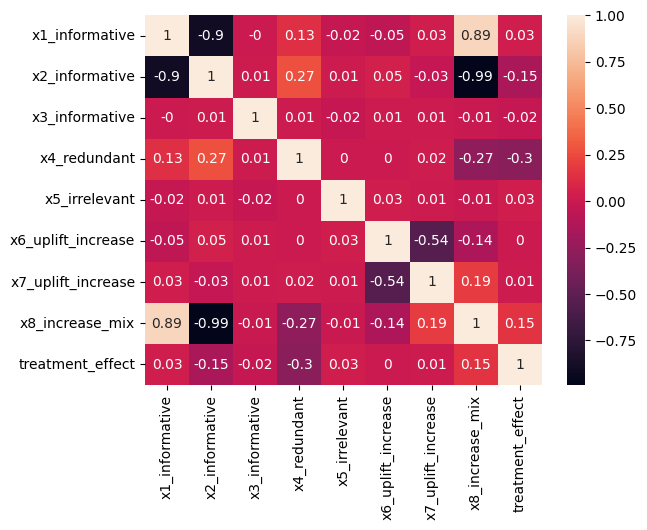

In [ ]:
import seaborn as sb
sb.heatmap(df.drop('conversion', axis=1).corr().round(2), annot=True)

Feature eliminations:
1. `x1_informative` and `x2_informative` highly negatively correlated, one of them has to go.
2. `x1_informative` and `x8_informative` highly negatively correlated, one of them has to go.
3. `x2_informative` and `x8_informative` highly negatively correlated, one of them has to go.
4. `x6_uplift_increase` and `x7_uplift_increase` considerably highly negatively correlated, one of them should go.
5. `x1_informative, x6_uplift_increase, x7_uplift_increase` shall be removed.

<Axes: >

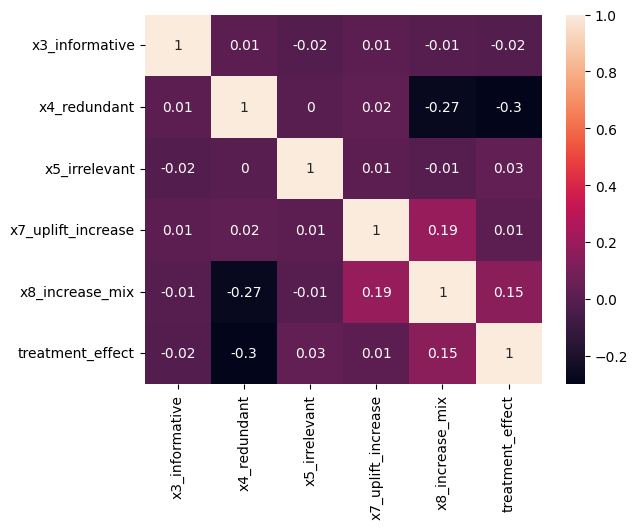

In [ ]:
sb.heatmap(df.drop(['conversion', 'x1_informative', 'x2_informative', 'x6_uplift_increase'], axis=1).corr().round(2), annot=True)

In [ ]:
df.drop(['x1_informative', 'x2_informative', 'x6_uplift_increase'], axis=1, inplace=True)

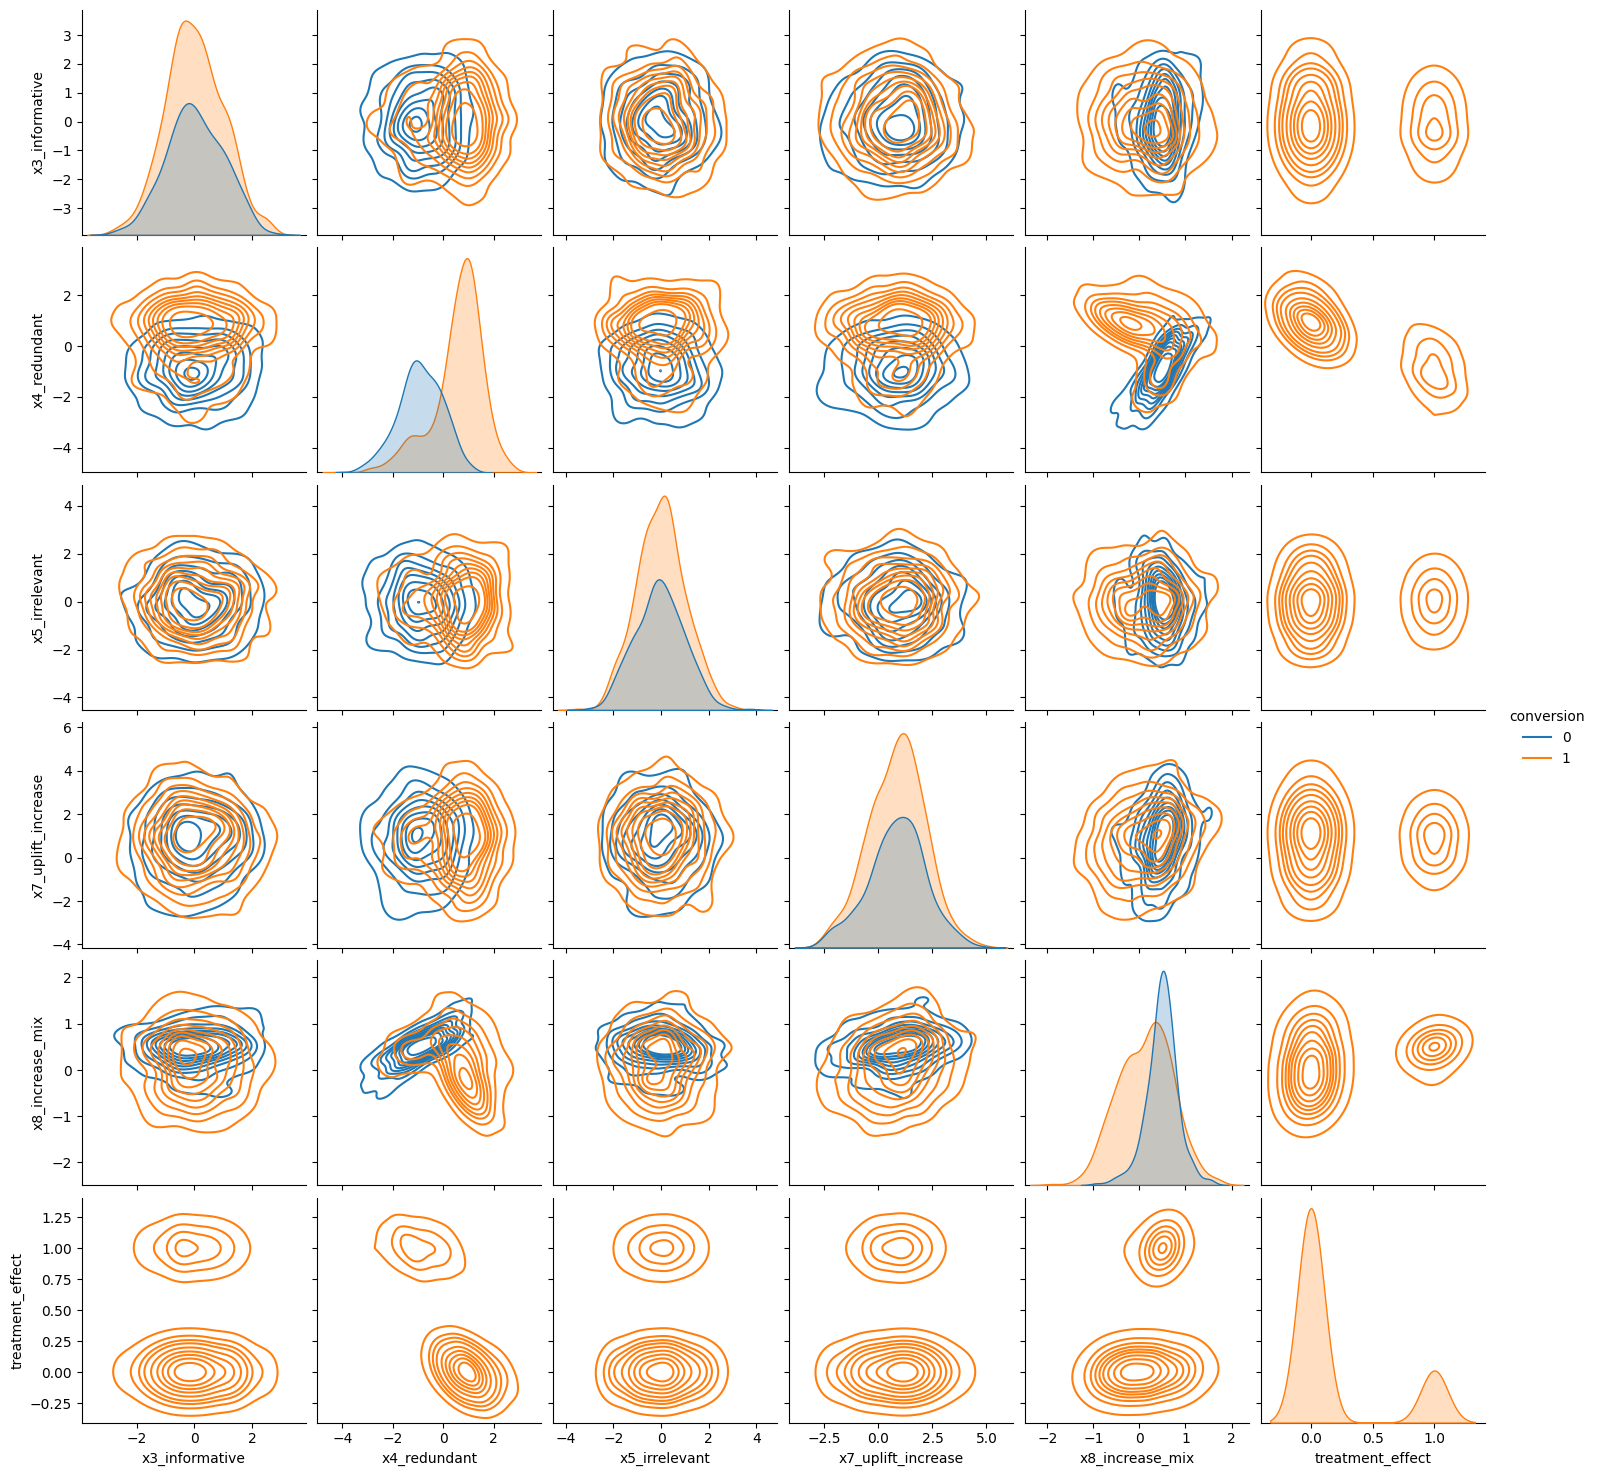

In [ ]:
sb.pairplot(df.drop(['treatment_group_key'], axis=1), hue='conversion', kind='kde')

In [ ]:
for x in ['x1_informative', 'x2_informative', 'x6_uplift_increase']:
  feature_names.remove(x)

feature_names

['x3_informative',
 'x4_redundant',
 'x5_irrelevant',
 'x7_uplift_increase',
 'x8_increase_mix']

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)
print(f"#Train samples = {df_train.shape[0]}, #Test samples = {df_test.shape[0]}")

#Train samples = 800, #Test samples = 200


In [ ]:
df_train['conversion'].value_counts(), df_train['treatment_group_key'].value_counts()

(1    483
 0    317
 Name: conversion, dtype: int64,
 control      582
 treatment    218
 Name: treatment_group_key, dtype: int64)

In [ ]:
df_test['conversion'].value_counts(), df_test['treatment_group_key'].value_counts()

(1    136
 0     64
 Name: conversion, dtype: int64,
 control      154
 treatment     46
 Name: treatment_group_key, dtype: int64)

In [ ]:
df_train[['treatment_group_key','conversion']].value_counts()

treatment_group_key  conversion
control              0             310
                     1             272
treatment            1             211
                     0               7
dtype: int64

In [ ]:
df_test[['treatment_group_key','conversion']].value_counts()

treatment_group_key  conversion
control              1             91
                     0             63
treatment            1             45
                     0              1
dtype: int64

1. Good, remaining features are not at all correlated with each other, which is desirable.
2. the above `value_counts` from the `train_set` tells us that in the control group, more samples show no response than those who show a positive response.
  1. and more samples show a positive response in the treatment group, than those that show no response.
3. However, the `test_set` tells us that regardless of providing treatment or not, positive responders are more in number than no-responders.

# Feature Selection using `causalml.feature_selection.filters.FilterSelect`
1. calculated for a given treatment-group
  1. it could be that for each treatment-group, the importances could be different.

## F Filter method
1. F-statistic computed for F-test performed on each `<feature, outcome, treatment>` combination, for the `treatment` provided as argument.
  1. null hypothesis of F-test: feature(confounder) has no effect on both treatment and outcome variables.
  2. p-value in results: probability of this being true.
2. w.r.t. a feature, say `feat1`, we see the following:
  1. whether a linear regressor exists with its features as:
    1. `feat1`
    2. `treatment_indicator`(=1 if `treatment_group_key=treatment`(provided in argument), =0 otherwise)
    3. `feat1 * treatment_indicator`(interaction term)
    4. this means that the coefficient of the interaction term is non-zero.
    5. the null hypothesis is that the coefficient is zero, i.e. **interaction of feature with treatment is independent of outcome**.
    6. this hypothesis is represented as the restriction matrix `rmatrix=[0,0,0,1]`
      1. this states that `0 * β_linear1 + 0 * β_feat1 + 0 * β_treatment + 1 * β_feat1_treatment = 0`
      2. in other words: `H0: β_feat1_treatment = 0`.
  2. the **problem statement** of F-test/F-statistic is checking whether the **interaction term of feature** and **treatment** variable has any **effect on** the **outcome** variable.
3. `f_test` from `statsmodels` is used([`LikelihoodModelResults.f_test`](https://github.com/statsmodels/statsmodels/blob/main/statsmodels/base/model.py#L1693)).
  1. under the hood, this generates an F-statistic value for the hypothesis/hypotheses being tested.
  2. the p-value is obtained from the complementary cumulative F-distribution function evaluated on x=f-stat value given
  2. [`scipy.stats.f`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html)(using [`scipy.special.fdtrc`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.fdtrc.html)) is used to generated a continuous f-distribution using the parameters `df_denom,df_num,x`.
4. `order=2` means that:
  1. for each feature, its squared value, i.e. `feat1 ** 2` is generated.
  2. the restriction matrix becomes a 2d one: `rmatrix = [[0,0,0,1,0,0],[0,0,0,0,0,1]]`.
  3. such a 2d rmatrix means 2 hypotheses being tested
    1. outcome is independent of interaction term of feature and treatment.
    2. outcome is independent of interaction term between 2nd order of feature  and treatment.
5. `order=3` means that:
  1. for each feature, its squared and cubed valueß, i.e. `feat1 ** 2, feat1 ** 3` are generated.
  2. the restriction matrix becomes a 2d one: `rmatrix = [[0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,1]]`.
  3. such an rmatrix means 3 hypotheses being tested
    1. outcome is independent of interaction term of feature and treatment.
    2. outcome is independent of interaction term between 2nd order of feature  and treatment.
    3. outcome is independent of interaction term between 3rd order of feature  and treatment.

In [ ]:
from causalml.feature_selection.filters import FilterSelect
filter_method = FilterSelect()

y_name='conversion'

# F Filter with order 1
method = 'F'
f_imp = filter_method.get_importance(
    df_train,
    feature_names,
    y_name,
    method,
    treatment_group = 'treatment'
)
f_imp.head()

,method,feature,rank,score,p_value,misc
0,F filter,x4_redundant,1.0,242.168958,7.151094e-48,"df_num: 1.0, df_denom: 796.0, order:1"
0,F filter,x8_increase_mix,2.0,39.298951,5.956458e-10,"df_num: 1.0, df_denom: 796.0, order:1"
0,F filter,x7_uplift_increase,3.0,2.469297,1.164872e-01,"df_num: 1.0, df_denom: 796.0, order:1"
0,F filter,x5_irrelevant,4.0,0.229352,6.321360e-01,"df_num: 1.0, df_denom: 796.0, order:1"
0,F filter,x3_informative,5.0,0.024758,8.750111e-01,"df_num: 1.0, df_denom: 796.0, order:1"


In [ ]:
# F Filter with order 2
method = 'F'
f_imp = filter_method.get_importance(
    df_train,
    feature_names,
    y_name,
    method,
    treatment_group = 'treatment',
    order=2
)
f_imp.head()

,method,feature,rank,score,p_value,misc
0,F filter,x4_redundant,1.0,119.306516,4.960343e-46,"df_num: 2.0, df_denom: 794.0, order:2"
0,F filter,x7_uplift_increase,2.0,2.949339,5.294837e-02,"df_num: 2.0, df_denom: 794.0, order:2"
0,F filter,x8_increase_mix,3.0,1.753164,1.738949e-01,"df_num: 2.0, df_denom: 794.0, order:2"
0,F filter,x3_informative,4.0,0.448759,6.385816e-01,"df_num: 2.0, df_denom: 794.0, order:2"
0,F filter,x5_irrelevant,5.0,0.164608,8.482549e-01,"df_num: 2.0, df_denom: 794.0, order:2"


In [ ]:
# F Filter with order 3
method = 'F'
f_imp = filter_method.get_importance(
    df_train,
    feature_names,
    y_name,
    method,
    treatment_group = 'treatment',
    order=3
)
f_imp.head()

,method,feature,rank,score,p_value,misc
0,F filter,x4_redundant,1.0,92.244810,3.331182e-51,"df_num: 3.0, df_denom: 792.0, order:3"
0,F filter,x8_increase_mix,2.0,3.162676,2.400464e-02,"df_num: 3.0, df_denom: 792.0, order:3"
0,F filter,x7_uplift_increase,3.0,1.426615,2.336475e-01,"df_num: 3.0, df_denom: 792.0, order:3"
0,F filter,x5_irrelevant,4.0,0.356287,7.846072e-01,"df_num: 3.0, df_denom: 792.0, order:3"
0,F filter,x3_informative,5.0,0.069342,9.762663e-01,"df_num: 3.0, df_denom: 792.0, order:3"


### F-test code (under the hood)

In [ ]:
import statsmodels.api as sm

data = df_train.copy()
feature_name = feature_names[0]
y_name = 'conversion'
experiment_group_column="treatment_group_key"
control_group, treatment_group = "control", "treatment"
treatment_indicator = "treatment_indicator"

data = data[
    data[experiment_group_column].isin([control_group, treatment_group])
]
data["treatment_indicator"] = 0
data.loc[
    data[experiment_group_column] == treatment_group, "treatment_indicator"
] = 1

Y = data[y_name]
X = data[[treatment_indicator, feature_name]]
X = sm.add_constant(X)
X["{}-{}".format(treatment_indicator, feature_name)] = X[
    [treatment_indicator, feature_name]
].product(axis=1)

order = 2
x_tmp_name = "{}_o{}".format(feature_name, order)
X[x_tmp_name] = X[[feature_name]] ** order
X["{}-{}".format(treatment_indicator, x_tmp_name)] = X[
    [treatment_indicator, x_tmp_name]
].product(axis=1)

X.head(3)

,const,treatment_indicator,x3_informative,treatment_indicator-x3_informative,x3_informative_o2,treatment_indicator-x3_informative_o2
29,1.0,1,-0.312516,-0.312516,0.097666,0.097666
535,1.0,1,-1.178440,-1.178440,1.388722,1.388722
695,1.0,0,1.827262,0.000000,3.338885,0.000000


In [ ]:
sm_model = sm.OLS(Y, X)
result = sm_model.fit()
print(result.f_test(np.array([[0,0,0,1,0,0], [0,0,0,0,0,1]])))

<F test: F=0.15314834033941815, p=0.8580277748743352, df_denom=794, df_num=2>


In [ ]:
try:
  print(f"resid_inference = {result.df_resid_inference}")
except:
  try:
    print(result.df_resid)
  except:
    print("Pffft!!!")


794.0


In [ ]:
print(sm_model.df_resid)

794.0


#### Order=1

In [ ]:
from patsy import DesignInfo

names = result.model.data.cov_names
r_matrix = np.array([0,0,0,1])
params = result.params.ravel(order="F")
LC = DesignInfo(names).linear_constraint(r_matrix)
r_matrix, q_matrix = LC.coefs, LC.constants

cparams = np.dot(r_matrix, params[:, None])

J = float(r_matrix.shape[0])  # number of hypotheses

if q_matrix is None:
    q_matrix = np.zeros(J)
else:
    q_matrix = np.asarray(q_matrix)
if q_matrix.ndim == 1:
    q_matrix = q_matrix[:, None]
    if q_matrix.shape[0] != J:
        raise ValueError("r_matrix and q_matrix must have the same "
                          "number of rows")
Rbq = cparams - q_matrix

print(J, params, cparams, q_matrix, Rbq)

1.0 [ 0.47937127  0.47696393  0.00881032 -0.01576528] [[-0.01576528]] [[0.]] [[-0.01576528]]


In [ ]:
display(result.normalized_cov_params)

,const,treatment_indicator,x3_informative,treatment_indicator-x3_informative
const,0.001628,-0.001628,-0.000060,0.000060
treatment_indicator,-0.001628,0.007051,0.000060,0.000235
x3_informative,-0.000060,0.000060,0.001737,-0.001737
treatment_indicator-x3_informative,0.000060,0.000235,-0.001737,0.006610


#### Order=2

In [ ]:
print(result.model.data.cov_names)

['const', 'treatment_indicator', 'x3_informative', 'treatment_indicator-x3_informative', 'x3_informative_o2', 'treatment_indicator-x3_informative_o2']


In [ ]:
from patsy import DesignInfo

names = result.model.data.cov_names
r_matrix = np.array([[0,0,0,1,0,0], [0,0,0,0,0,1]])
params = result.params.ravel(order="F")
LC = DesignInfo(names).linear_constraint(r_matrix)
r_matrix, q_matrix = LC.coefs, LC.constants

print(f"r_matrix = {r_matrix}")

cparams = np.dot(r_matrix, params[:, None])

J = float(r_matrix.shape[0])  # number of hypotheses

if q_matrix is None:
    q_matrix = np.zeros(J)
else:
    q_matrix = np.asarray(q_matrix)
print(q_matrix)
if q_matrix.ndim == 1:
    q_matrix = q_matrix[:, None]
    if q_matrix.shape[0] != J:
        raise ValueError("r_matrix and q_matrix must have the same "
                          "number of rows")
Rbq = cparams - q_matrix

print(J, "\n", params, "\n", cparams, "\n", q_matrix,"\n", Rbq)

r_matrix = [[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]
[[0.]
 [0.]]
2.0 
 [ 0.45268015  0.5097367   0.00824354 -0.01477035  0.02318463 -0.02665848] 
 [[-0.01477035]
 [-0.02665848]] 
 [[0.]
 [0.]] 
 [[-0.01477035]
 [-0.02665848]]


In [ ]:
result.params.ravel(order="F")

array([ 0.45268015,  0.5097367 ,  0.00824354, -0.01477035,  0.02318463,
       -0.02665848])

In [ ]:
cov_p = result.normalized_cov_params * result.scale

cov_p = np.dot(r_matrix, np.dot(cov_p, np.transpose(r_matrix)))

invcov = np.linalg.pinv(cov_p)
J_ = np.linalg.matrix_rank(cov_p)

In [ ]:
J, J_, invcov

(2.0,
 2,
 array([[ 649.24030865, -171.14148878],
        [-171.14148878, 1253.2510879 ]]))

In [ ]:
F = np.dot(np.dot(Rbq.T, invcov), Rbq)

In [ ]:
float(np.squeeze(F))/J

0.4487592603922012

## <font color="pink">Problems with this method of feature selection</font>
1. The approach assumes that there exists a linear relation between the outcome an the interaction term of `feature,treatment_indicator`.
2. In addition to this, it also assumes that the error(`y_hat_linear - y_target`) is standard normally distributed, which still may not be the case.
3. Refer to [F-statistic notes](https://github.com/akshayDev17/Machine-Learning-Concepts/blob/master/src/Causal%20Inferences/hypothesisTesting.ipynb).

## Likelihood Ratio Test Filter method
1. instead of OLS(in F-filter), logistic regression([statsmodel.Logit](https://github.com/statsmodels/statsmodels/blob/main/statsmodels/discrete/discrete_model.py#L2337)) is used, with its apt loss function
2. the feature generation based on order value is the exact same.
3. 2 logistic regressors are created:
  1. `model_r`(restricted) doesn't have any interaction terms as its features.
  2. `model_f`(free) has interaction terms as its features, in addition to the ones in `model_r`.
4. `LogitResults.llf --> LikelihoodResults.llf` --> [`Logit.loglike(results.params)`](https://github.com/statsmodels/statsmodels/blob/main/statsmodels/discrete/discrete_model.py#L2416) is the call sequence to the log-likelihood function, which computes the total log-likelihood of observing the given set of outcomes , given features taken.
5. The following is the last lines of this method
  ```
  LR_stat = -2 * (result_r.llf - result_f.llf)
  LR_df = len(result_f.params) - len(result_r.params)
  LR_pvalue = 1 - stats.chi2.cdf(LR_stat, df=LR_df)
  ```
    1. `LR_stat` measures the log-difference(or log(ratio of likelihood when interaction terms are not considered to when considered))
    2. `LR_stat` > 0 means that interaction term inclusion reduces the likelihood of observing the outcomes, **as per the logit(logistic regressor) trained**.
      1. conversely, negative LR_stat means that the probability/likelihood of observing the outcomes increases when the interaction terms are included while training the logistic regressor.
    3. if `LR_stat < 0`, `stats.chi2.cdf(LR_stat, df=LR_df)` will return 0 since chi-squared RV will definitionally be always non-negative.

In [ ]:
# LR(likelihood ratio-test) Filter with order 1
method = 'LR'
f_imp = filter_method.get_importance(
    df_train,
    feature_names,
    y_name,
    method,
    treatment_group = 'treatment',
    order=1
)
f_imp.head()

,method,feature,rank,score,p_value,misc
0,LR filter,x4_redundant,1.0,42.926706,5.682954e-11,"df: 1, order: 1"
0,LR filter,x7_uplift_increase,2.0,20.376684,6.359998e-06,"df: 1, order: 1"
0,LR filter,x5_irrelevant,3.0,2.984598,8.406017e-02,"df: 1, order: 1"
0,LR filter,x8_increase_mix,4.0,1.731500,1.882195e-01,"df: 1, order: 1"
0,LR filter,x3_informative,5.0,0.085560,7.698993e-01,"df: 1, order: 1"


In [ ]:
# LR(likelihood ratio-test) Filter with order 2
method = 'LR'
f_imp = filter_method.get_importance(
    df_train,
    feature_names,
    y_name,
    method,
    treatment_group = 'treatment',
    order=2
)
f_imp.head()

,method,feature,rank,score,p_value,misc
0,LR filter,x7_uplift_increase,1.0,18.912909,0.000078,"df: 2, order: 2"
0,LR filter,x4_redundant,2.0,14.789249,0.000615,"df: 2, order: 2"
0,LR filter,x8_increase_mix,3.0,6.320410,0.042417,"df: 2, order: 2"
0,LR filter,x3_informative,4.0,3.748363,0.153481,"df: 2, order: 2"
0,LR filter,x5_irrelevant,5.0,0.669824,0.715401,"df: 2, order: 2"


In [ ]:
# LR(likelihood ratio-test) Filter with order 3
method = 'LR'
f_imp = filter_method.get_importance(
    df_train,
    feature_names,
    y_name,
    method,
    treatment_group = 'treatment',
    order=3
)
f_imp.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,method,feature,rank,score,p_value,misc
0,LR filter,x7_uplift_increase,1.0,18.972353,0.000277,"df: 3, order: 3"
0,LR filter,x4_redundant,2.0,17.203376,0.000642,"df: 3, order: 3"
0,LR filter,x8_increase_mix,3.0,7.292171,0.063146,"df: 3, order: 3"
0,LR filter,x3_informative,4.0,4.030617,0.258177,"df: 3, order: 3"
0,LR filter,x5_irrelevant,5.0,0.661015,0.882333,"df: 3, order: 3"


### Likelihood Ratio Test (under the hood)

In [ ]:
import statsmodels.api as sm

data = df_train.copy()
feature_name = feature_names[0]
y_name = 'conversion'
experiment_group_column="treatment_group_key"
control_group, treatment_group = "control", "treatment"
treatment_indicator = "treatment_indicator"

data = data[
    data[experiment_group_column].isin([control_group, treatment_group])
]
data["treatment_indicator"] = 0
data.loc[
    data[experiment_group_column] == treatment_group, "treatment_indicator"
] = 1

Y = data[y_name]
X = data[[treatment_indicator, feature_name]]
X = sm.add_constant(X)
X["{}-{}".format(treatment_indicator, feature_name)] = X[
    [treatment_indicator, feature_name]
].product(axis=1)

# order = 2
# x_tmp_name = "{}_o{}".format(feature_name, order)
# X[x_tmp_name] = X[[feature_name]] ** order
# X["{}-{}".format(treatment_indicator, x_tmp_name)] = X[
#     [treatment_indicator, x_tmp_name]
# ].product(axis=1)

X.head(3)

,const,treatment_indicator,x3_informative,treatment_indicator-x3_informative
29,1.0,0,-0.312516,-0.0
535,1.0,0,-1.178440,-0.0
695,1.0,0,1.827262,0.0


#### Order 1

In [ ]:
x_name_r = ["const", treatment_indicator, feature_name]
x_name_f = x_name_r.copy()
X = data[[treatment_indicator, feature_name]]
X = sm.add_constant(X)

X["{}-{}".format(treatment_indicator, feature_name)] = X[
    [treatment_indicator, feature_name]
].product(axis=1)
x_name_f.append("{}-{}".format(treatment_indicator, feature_name))

print(f"x_name_r={x_name_r}, x_name_f={x_name_f}")

x_name_r=['const', 'treatment_indicator', 'x3_informative'], x_name_f=['const', 'treatment_indicator', 'x3_informative', 'treatment_indicator-x3_informative']


In [ ]:
# Full model (with interaction)
model_r = sm.Logit(Y, X[x_name_r])
result_r = model_r.fit(disp=True)

model_f = sm.Logit(Y, X[x_name_f])
result_f = model_f.fit(disp=True)

Optimization terminated successfully.
         Current function value: 0.541407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.541354
         Iterations 7


In [ ]:
print(f"Params = {result_r.params}")

Params = const                 -0.130938
treatment_indicator    3.537171
x3_informative         0.003635
dtype: float64


In [ ]:
model_r.predict(result_r.params, which="linear")

array([-0.13207356, -0.13522108, -0.12429577, -0.12977579,  3.40377795,
       -0.13181634, -0.12876128, -0.13230811,  3.40691403,  3.4036713 ,
       -0.13128405, -0.13591108,  3.40452396, -0.12949083, -0.13356185,
       -0.13607111, -0.13224655, -0.13028395, -0.13283467, -0.13160067,
        3.40579726,  3.3995231 , -0.12894948, -0.12979452,  3.40119739,
       -0.12480036,  3.40746273,  3.40532383, -0.1391093 ,  3.4081357 ,
        3.40492939, -0.12780502, -0.13466332, -0.13308185,  3.41013303,
       -0.12990914, -0.13230248,  3.40394562, -0.13370116, -0.13258796,
       -0.13432045, -0.13467634, -0.13180819,  3.41195956, -0.12401526,
       -0.13266179, -0.12518189, -0.1339038 , -0.13015675, -0.129083  ,
       -0.12675531, -0.12652995, -0.12823363, -0.13035731, -0.13505471,
       -0.13094761,  3.40514112,  3.40458625, -0.13045682, -0.13658411,
       -0.13332555, -0.13895764,  3.40573942, -0.13237747,  3.40467364,
       -0.13090321, -0.13263808, -0.13157351,  3.39907255, -0.13

In [ ]:
q = 2*model_r.endog - 1
linpred = model_r.predict(result_r.params, which="linear")
# return np.sum(np.log(self.cdf(q * linpred)))

In [ ]:
linpred.min(), linpred.max()

(-0.14147832405156657, 3.4158475760046283)

In [ ]:
print(np.sum(np.log(model_r.cdf(q * q))))

-250.60935001457818


In [ ]:
print(np.exp(np.sum(np.log(model_r.cdf(q * q)))))

1.451249808061798e-109


In [ ]:
print(result_r.llf, model_r.loglike(result_r.params))

-433.12572665681813 -433.12572665681813


## KL Divergence method
1. for each feature `feature_i`, divide the data into `n_bins` bins(default =10, i.e. decile calculation), i.e. 10 equally populated arrays.
2. for the $j^{th}$ bin
  1. all indices in the `df_train` contributing to this bin are selected.
  2. `pk`(probability of conversion if assigned to control) = proportion of samples with outcome=1(converted) in control group to total samples in control group in this bin.
  3. `qk_ti`(probability of conversion if assigned to treatment group `ti`) = proportion of samples with outcome=1(converted) in treatment `ti` group to total samples in treatment `ti` group in this bin.
  4. the term $p_k .log \left(\dfrac{pk}{qk\_ti}\right) + (1-p_k) .log \left(\dfrac{1-pk}{1-qk\_ti}\right)$ gives us the KL divergence of 2 distributions.
    1. KL divergence is defined at an event level.
    2. Event here = *conversion* if assigned to that group.
    3. this is again *defined for each treatment group*.
  5. for a certain subset of data, if `pk > qk_ti` it means that the first distribution assigns a higher probability of conversion, as opposed to the second one.
    1. here, $1^{st}$ distribution: assigning to treatment `ti`, $2^{nd}$ distribution: assigning to control group.
3. a weighted mean of KL divergence across all bins is calculated, where weight = number of samples in that bin.
  1. this will be called `d_children`
4. another KL divergence term, wherein all samples are considered for `pk`,`qk_ti` calculations is generated, referred to as `d_parent`.
5. the score for this feature is `d_children - d_parent`
6. if the absolute value of this score is very low, it means that the feature doesn't provide much discriminatory power in terms of the outcome for the treatment and control groups.
  1. In other words, the distribution of outcomes across treatment and control groups is similar regardless of the values of this feature(regardless whether this feature is taken or not).
7. A positive and high difference - feature leads to significant segregation in the distribution of outcomes between the treatment and control groups.
  1. feature might be influential in determining the response to treatment.
  2. i.e. feature is informative in terms of predicting uplift.
8. A negative and high difference suggests that the **feature leads to** an **opposite effect** compared to the full set.
  1. feature might be misleading when used in isolation for predicting uplift.
  2. It might indicate that the feature has an unexpected relationship with the treatment effect or interacts with other features in complex ways.
  3. scrutinize such features more carefully and perhaps consider interactions or non-linear effects.

## <font color="pink">Major Problems</font>
1. whatif for a given bin, there doesn't exist any sample being converted, i.e. y=1, for either the treatment or control or both?
  1. in this case, `pk` or `qk_ti` or both can be 0, hence having a `NaN` log value, or division by 0 error.

In [ ]:
# KL Filter with deciles
method = 'KL'
f_imp = filter_method.get_importance(
    df_train,
    feature_names,
    y_name,
    method,
    treatment_group = 'treatment',
    n_bins=10
)
f_imp.head()

/usr/local/lib/python3.10/dist-packages/causalml/feature_selection/filters.py:342: RuntimeWarning: divide by zero encountered in log
  S = pk * np.log(pk / qk) + (1 - pk) * np.log((1 - pk) / (1 - qk))
/usr/local/lib/python3.10/dist-packages/causalml/feature_selection/filters.py:342: RuntimeWarning: invalid value encountered in scalar multiply
  S = pk * np.log(pk / qk) + (1 - pk) * np.log((1 - pk) / (1 - qk))


,method,feature,rank,score,p_value,misc
0,KL filter,x8_increase_mix,1.0,0.074859,None,number_of_bins: 10
0,KL filter,x7_uplift_increase,2.0,-0.052891,None,number_of_bins: 10
0,KL filter,x3_informative,3.0,-0.062375,None,number_of_bins: 10
0,KL filter,x5_irrelevant,4.0,-0.063015,None,number_of_bins: 10
0,KL filter,x4_redundant,NaN,NaN,None,number_of_bins: 10


In [ ]:
# KL Filter with number of bins = 5
method = 'KL'
f_imp = filter_method.get_importance(
    df_train,
    feature_names,
    y_name,
    method,
    treatment_group = 'treatment',
    n_bins=5
)
f_imp.head()

,method,feature,rank,score,p_value,misc
0,KL filter,x4_redundant,1.0,0.952314,None,number_of_bins: 5
0,KL filter,x8_increase_mix,2.0,0.127437,None,number_of_bins: 5
0,KL filter,x5_irrelevant,3.0,0.000329,None,number_of_bins: 5
0,KL filter,x3_informative,4.0,-0.008924,None,number_of_bins: 5
0,KL filter,x7_uplift_increase,5.0,-0.010660,None,number_of_bins: 5


### KL (under the hood)

In [ ]:
x_bin = pd.qcut(df_train[feature_name].values, 10, labels=False, duplicates="drop")
experiment_group_column, y_name = 'treatment_group_key', 'conversion'
np.nanmax(x_bin).astype(int)

9

In [ ]:
d_children = 0
totalSize = df_train.shape[0]

for i_bin in range(min(x_bin), max(x_bin)+1):
  data=df_train.loc[x_bin == i_bin]

  # Counts of conversions by treatment group
  results_series = data.groupby([experiment_group_column, y_name]).size()

  treatment_group_keys = results_series.index.levels[0].tolist()
  y_name_keys = results_series.index.levels[1].tolist()

  results = {}
  for ti in treatment_group_keys:
    results.update({ti: {}})
    for ci in y_name_keys:
      results[ti].update(
          {
              ci: (
                  results_series[ti, ci]
                  if results_series.index.isin([(ti, ci)]).any()
                  else 1
              )
          }
      )

  # Probability of conversion and group size by treatment group
  nodeSummary = {}
  for treatment_group_key in results:
    n_1 = results[treatment_group_key].get(1, 0)
    n_total = results[treatment_group_key].get(1, 0) + results[
        treatment_group_key
    ].get(0, 0)
    y_mean = 1.0 * n_1 / n_total
    nodeSummary[treatment_group_key] = [y_mean, n_total]

  pk, qk = nodeSummary['treatment'][0], nodeSummary['control'][0]

  nodeScore = pk * np.log(pk/qk) + (1-pk) * np.log((1-pk)/(1-qk))
  nodeSize = sum([x[1] for x in list(nodeSummary.values())])

  d_children += (nodeScore*nodeSize)/totalSize
  print(round(d_children, 3))
  print(nodeSummary, "\n")

0.055
{'control': [0.4339622641509434, 53], 'treatment': [0.9259259259259259, 27]} 

0.089
{'control': [0.6, 60], 'treatment': [0.9523809523809523, 21]} 

0.148
{'control': [0.4576271186440678, 59], 'treatment': [0.9523809523809523, 21]} 

0.235
{'control': [0.36, 50], 'treatment': [0.967741935483871, 31]} 

0.304
{'control': [0.41379310344827586, 58], 'treatment': [0.9565217391304348, 23]} 

0.355
{'control': [0.5, 60], 'treatment': [0.9523809523809523, 21]} 

0.412
{'control': [0.4666666666666667, 60], 'treatment': [0.9523809523809523, 21]} 

0.467
{'control': [0.4745762711864407, 59], 'treatment': [0.9523809523809523, 21]} 

0.499
{'control': [0.4666666666666667, 60], 'treatment': [0.85, 20]} 

0.552
{'control': [0.47619047619047616, 63], 'treatment': [0.9444444444444444, 18]} 



In [ ]:
data = df_train.copy()

# Counts of conversions by treatment group
results_series = data.groupby([experiment_group_column, y_name]).size()

treatment_group_keys = results_series.index.levels[0].tolist()
y_name_keys = results_series.index.levels[1].tolist()

results = {}
for ti in treatment_group_keys:
  results.update({ti: {}})
  for ci in y_name_keys:
    results[ti].update(
        {
            ci: (
                results_series[ti, ci]
                if results_series.index.isin([(ti, ci)]).any()
                else 1
            )
        }
    )

# Probability of conversion and group size by treatment group
parent_nodeSummary = {}
for treatment_group_key in results:
  n_1 = results[treatment_group_key].get(1, 0)
  n_total = results[treatment_group_key].get(1, 0) + results[
      treatment_group_key
  ].get(0, 0)
  y_mean = 1.0 * n_1 / n_total
  parent_nodeSummary[treatment_group_key] = [y_mean, n_total]

pk, qk = parent_nodeSummary['treatment'][0], parent_nodeSummary['control'][0]
print(parent_nodeSummary, "\n")
print(f"For parent node, pk = {round(pk, 3)}, qk = {round(qk, 3)}")
d_parent = pk * np.log(pk/qk) + (1-pk) * np.log((1-pk)/(1-qk))

{'control': [0.46735395189003437, 582], 'treatment': [0.9678899082568807, 218]} 

For parent node, pk = 0.968, qk = 0.467


In [ ]:
results_series

treatment_group_key  conversion
control              0             310
                     1             272
treatment            0               7
                     1             211
dtype: int64

In [ ]:
d_res = d_children - d_parent
d_res

-0.062375150620928355

In [ ]:
pk_arr, qk_arr = [1/11, 4/14, 5/15, 15/25, 25/35], [0.5, 0.5, 0.5, 0.5, 0.5]
tot_score = 0
for i in range(len(pk_arr)):
  pk_i, qk_i = pk_arr[i], qk_arr[i]
  curr_score = pk_i*np.log(pk_i/qk_i) + (1-pk_i)*np.log((1-pk_i)/(1-qk_i))
  tot_score += curr_score
  print(i, round(curr_score, 3), round(pk_i, 3), round(qk_i, 3))
print(tot_score)

0 0.389 0.091 0.5
1 0.095 0.286 0.5
2 0.057 0.333 0.5
3 0.02 0.6 0.5
4 0.095 0.714 0.5
0.6550347929759046


In [ ]:
pk_arr, qk_arr = [0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5]
tot_score = 0
for i in range(len(pk_arr)):
  pk_i, qk_i = pk_arr[i], qk_arr[i]
  curr_score = pk_i*np.log(pk_i/qk_i) + (1-pk_i)*np.log((1-pk_i)/(1-qk_i))
  tot_score += curr_score
print(tot_score)

0.0


In [ ]:
feature_name

'x3_informative'

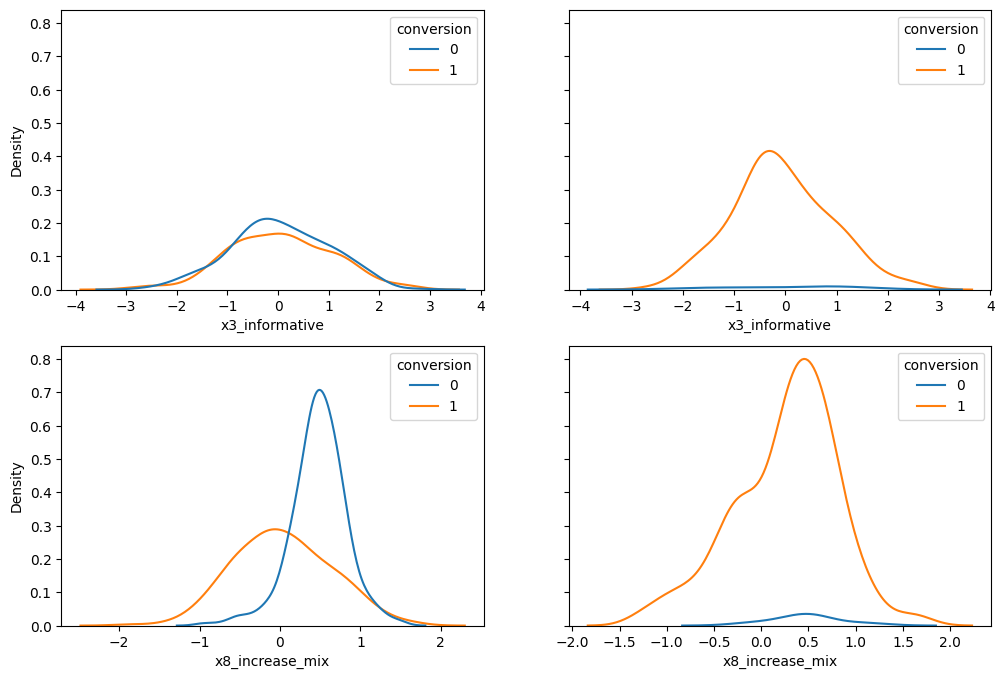

In [ ]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(12, 8))

sb.kdeplot(data=df_train[df_train['treatment_group_key']=='control'], x="x3_informative", hue="conversion", ax=ax[0][0])
sb.kdeplot(data=df_train[df_train['treatment_group_key']=='treatment'], x="x3_informative", hue="conversion", ax=ax[0][1])

sb.kdeplot(data=df_train[df_train['treatment_group_key']=='control'], x="x8_increase_mix", hue="conversion", ax=ax[1][0])
sb.kdeplot(data=df_train[df_train['treatment_group_key']=='treatment'], x="x8_increase_mix", hue="conversion", ax=ax[1][1])
plt.show()

## Conclusion from importance values
1. Across all feature selector methods
  1.